In [42]:
import pandas as pd
from pyspark.sql.functions import (col, rand, udf, collect_set, collect_list, concat, array_distinct, flatten, when, length)
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType, FloatType
from unidecode import unidecode
import re
from functools import reduce
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, GlobalMaxPooling1D, Layer, Masking, Lambda, Permute
import os
import pickle
from keras.layers import Bidirectional
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import functools


In [2]:
#env: geoNames

In [240]:
names_data = pd.read_csv('../../data/02_intermediate/names/names.csv')
print(names_data.shape)
names_data['name_2'] = names_data['name_2'].apply(lambda x: x[:-3] if '(' in x else x)
names_data['name_1'] = names_data['name_1'].apply(lambda x: x[:-3] if '(' in x else x)
names_data['name_2'] = names_data['name_2'].apply(lambda x: x.split('|'))
names_data = names_data.explode('name_2')
print(names_data.shape)

(8160, 3)
(9235, 3)


In [242]:
names_data.sample(10)

,name_1,name_2,target
184,AMERICAN ASSOCIATION FOR THE UNITED NATIONS,SONOMA STATE UNIVERSITY ACADEMIC FOUNDATION INC,0
2000,LABORERS INTERNATIONAL UNION OF NORTH AMERICA,LABORS INTERNATIONAL UNION OF AMERICA,1
1281,EAST SLOPE TAXPAYERS ASSOCIATIONCUT BANK,TEXAS BANKERS ASSOCIATION PAC STATE,0
1684,HMONG AMERICAN PARTNERSHIP,INSURANCE BROKERS AND AGENTS OF BURBANK GLENDA...,0
4836,Jan Schakowsky,Janice Schakowsky,1
1995,LABORERS INTERNATIONAL UNION OF NORTH AMERICA,LABORERS INTERNATIONAL UNION OF NORTH AMERICA ...,1
6885,efficiently,effeciently,1
3502,STB ENTERPRISES INC,TZ & LS ENTERPRISES INC,0
4265,G. Peter Zhang,Guoqiang Peter Zhang,1
6356,natural,naturual,1


# 2. Function to normalize names

Requirements:

* Transform to unicode characters (utf-8)
* remove whitespaces

In [243]:
def normalize_characters(text: str) -> str:
    
    if text is None:
        return ''

    strange_char_space = r"!#$%&()*+,./:;<=>?@[\]^_{|}~ºª®-"
    char_2_remove = "\"'^`"
    space_mask = "                                "
    punctuation_table = str.maketrans(strange_char_space, space_mask,
                                        char_2_remove)
    text = text.lower()
    text = text.strip()
    text = unidecode(text)
    text = text.translate(punctuation_table)
    text = re.sub(r' +', ' ', text)
    text = text.strip()
    text = text.lower()

    return text

udf_normalize_chars = udf(normalize_characters)

In [244]:
names_data['name_1_normalized'] = names_data['name_1'].apply(lambda x: normalize_characters(x))
names_data['name_2_normalized'] = names_data['name_2'].apply(lambda x: normalize_characters(x))

# 3. Function to generate vocabulary

In [245]:
def get_unique_characters(string: str) -> list:

    unique_characters = list(set(string))
    return unique_characters

udf_get_unique_characters = udf(get_unique_characters, ArrayType(StringType()))


def compute_max_word_len(string: str) -> int:
    return max([len(word) for word in string.split(' ')])

udf_compute_max_word_len = udf(compute_max_word_len)

def compute_token_count(string: str) -> int:
    return len([word for word in string.split(' ')])

udf_compute_token_count = udf(compute_token_count)

In [246]:
chars_1 = names_data['name_1_normalized'].apply(lambda x: get_unique_characters(x)).values
chars_2 = names_data['name_2_normalized'].apply(lambda x: get_unique_characters(x)).values

In [247]:
chars_1_unique = sorted(functools.reduce(lambda x, y: list(set(x+y)), chars_1))
chars_2_unique = sorted(functools.reduce(lambda x, y: list(set(x+y)), chars_2))

In [248]:
characters_list = list(set(chars_1_unique+chars_2_unique))
sorted_char_list = sorted(characters_list)

In [249]:
sorted_char_list


[
    ' ',
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9',
    'a',
    'b',
    'c',
    'd',
    'e',
    'f',
    'g',
    'h',
    'i',
    'j',
    'k',
    'l',
    'm',
    'n',
    'o',
    'p',
    'q',
    'r',
    's',
    't',
    'u',
    'v',
    'w',
    'x',
    'y',
    'z'
]

# 4. One Hot encoder

In [250]:
char_to_index = {char: index for index, char in enumerate(sorted_char_list)}
index_to_char = {index: char for char, index in char_to_index.items()}
MAX_WORD_LENGTH = 16
MAX_TOKEN_NUMBER = 8
MAX_NAME_LEN = 100

In [251]:
char_to_index


{
    ' ': 0,
    '0': 1,
    '1': 2,
    '2': 3,
    '3': 4,
    '4': 5,
    '5': 6,
    '6': 7,
    '7': 8,
    '8': 9,
    '9': 10,
    'a': 11,
    'b': 12,
    'c': 13,
    'd': 14,
    'e': 15,
    'f': 16,
    'g': 17,
    'h': 18,
    'i': 19,
    'j': 20,
    'k': 21,
    'l': 22,
    'm': 23,
    'n': 24,
    'o': 25,
    'p': 26,
    'q': 27,
    'r': 28,
    's': 29,
    't': 30,
    'u': 31,
    'v': 32,
    'w': 33,
    'x': 34,
    'y': 35,
    'z': 36
}

In [252]:
def one_hot_encoder(string: str, char_to_index_dict: dict) -> np.array:

    vocabulary_size = len(char_to_index_dict.keys())
    vector = np.zeros(vocabulary_size)
    for char in string:
        vector[char_to_index[char]-1] = 1 
    return vector

def encode_name_list(iterable: iter, char_to_index_dict: dict) -> np.array:

    return np.array([one_hot_encoder(string, char_to_index_dict) for string in iterable])

def check_chars_OOV(string: str, char_to_index_dict: dict) -> bool:

    vocabulary = char_to_index_dict.keys()
    return all([char in vocabulary for char in string])

def name_matrix_encoder(string: iter, char_to_index_dict: dict, max_word_length:int, max_token_number:int) -> np.array :

    representation_matrix = np.zeros(shape=(max_token_number, max_word_length))
    for token_ind, token in enumerate(string.split(' ')):
        for char_ind, char in enumerate(token):
            try:
                representation_matrix[token_ind][char_ind] = char_to_index[char]
            except IndexError:
                continue
    return representation_matrix

def sparse_encoder(string: str, char_to_index_dict: dict, max_len: int) -> np.array:

    vector = np.zeros(max_len)
    for ind, char in enumerate(string):
        if ind>=max_len:
            break
        vector[ind] = char_to_index[char]
    return vector

def encode_sparsed_list(iterable: iter, char_to_index_dict: dict, max_len: int) -> np.array:
    
    return np.array([sparse_encoder(string, char_to_index_dict, max_len) for string in iterable])

In [253]:
names_encoded_1 = np.array([name_matrix_encoder(name,
                                                char_to_index_dict=char_to_index,
                                                max_word_length=MAX_WORD_LENGTH,
                                                max_token_number=MAX_TOKEN_NUMBER
                                               ) for name in name_pairs[:, 0]], dtype=object)

names_encoded_2 = np.array([name_matrix_encoder(name,
                                                char_to_index_dict=char_to_index,
                                                max_word_length=MAX_WORD_LENGTH,
                                                max_token_number=MAX_TOKEN_NUMBER
                                               ) for name in name_pairs[:, 1]], dtype=object)

In [254]:
string1, string2 = 'dpe', 'daniel perez efremova'
strig1_matrix = name_matrix_encoder(string1, 
                                    char_to_index_dict=char_to_index,
                                    max_word_length=MAX_WORD_LENGTH,
                                    max_token_number=MAX_TOKEN_NUMBER)
strig2_matrix = name_matrix_encoder(string2, 
                                    char_to_index_dict=char_to_index,
                                    max_word_length=MAX_WORD_LENGTH,
                                    max_token_number=MAX_TOKEN_NUMBER)

In [255]:
def show_field(field1,field2):

    combined_data = np.array([field1,field2])
    #Get the min and max of all your data
    _min, _max = np.amin(combined_data), np.amax(combined_data)

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1, 2, 1)
    #Add the vmin and vmax arguments to set the color scale
    ax.imshow(field1,cmap=plt.cm.hot, vmin = _min, vmax = _max)
    ax.autoscale(False)
    ax2 = fig.add_subplot(1, 2, 2)
    #Add the vmin and vmax arguments to set the color scale
    ax2.imshow(field2,cmap=plt.cm.hot, vmin = _min, vmax = _max)
    ax2.autoscale(False)
    plt.show()

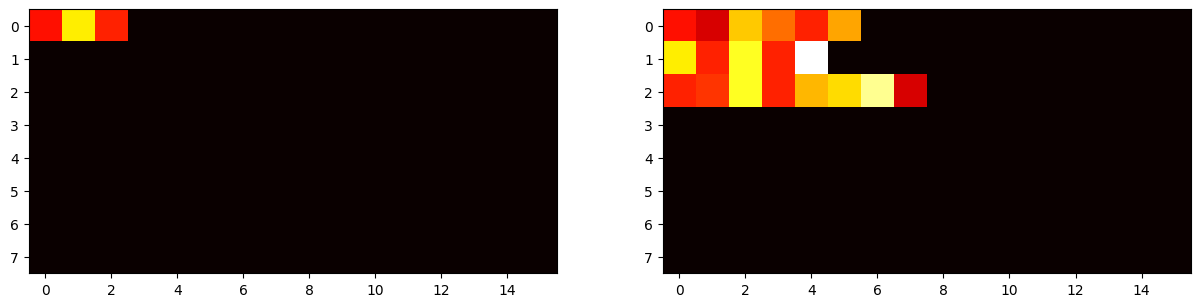

In [256]:
show_field(strig1_matrix, strig2_matrix)

# 5.1. Create a model class for char2vec embedding (One hot encoder - Siamese LSTM - Cosine similarity)

In [257]:
class poiNames_C2V:
    
    def __init__(self, embedding_size:int, char_to_index:dict):

        self.char_to_index = char_to_index
        self.index_to_char = {char_to_index[char]: char for char in char_to_index}
        self.input_size = MAX_NAME_LEN
        self.embedding_size = embedding_size

        lstm_input = tf.keras.layers.Input(shape=(self.input_size, 1,), name='lstm_input')
        x = tf.keras.layers.Masking(mask_value=0)(lstm_input)
        x = Bidirectional(tf.keras.layers.LSTM(self.embedding_size, return_sequences=True, name='lstm_1'))(x)
        x = Bidirectional(tf.keras.layers.LSTM(self.embedding_size, name='lstm_2'))(x)
        self.embedding_model = tf.keras.models.Model(inputs=[lstm_input], outputs=x)

        left_branch_input = tf.keras.layers.Input(shape=(self.input_size, 1), name='left_branch_input')
        right_branch_input = tf.keras.layers.Input(shape=(self.input_size, 1),name='right_branch_input')

        left_branch_embedding = self.embedding_model(left_branch_input)
        right_branch_embedding = self.embedding_model(right_branch_input)

        concat_layer = tf.keras.layers.Concatenate(axis=1)([left_branch_embedding, right_branch_embedding])
        product_layer = tf.keras.layers.Multiply()([left_branch_embedding, right_branch_embedding])
        difference_layer = tf.keras.layers.Subtract()([left_branch_embedding, right_branch_embedding])
        representation_layer = tf.keras.layers.Concatenate(axis=1)([concat_layer, product_layer, difference_layer])

        x = tf.keras.layers.Dropout(0.3)(representation_layer)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        model_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
                
        # x = tf.keras.layers.Dot(axes=1, normalize=True)([left_branch_embedding, right_branch_embedding]) # cosine similarity
        # model_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        
        self.model = tf.keras.models.Model(inputs=[left_branch_input, right_branch_input], outputs=model_output)
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',
                                                              tf.keras.metrics.Precision(),
                                                              tf.keras.metrics.Recall()])
        
    def fit(
        self, name_pairs, target, max_epochs:int, patience:int, validation_split:float, batch_size:int, callbacks: iter):

        print(f'Encoding names... ({2*len(name_pairs)})')
        # X1 = encode_name_list(name_pairs[:, 0],char_to_index_dict=self.char_to_index)
        # X2 = encode_name_list(name_pairs[:, 1], char_to_index_dict=self.char_to_index)

        X1 = encode_sparsed_list(name_pairs[:, 0],char_to_index_dict=self.char_to_index, max_len=MAX_NAME_LEN)
        X2 = encode_sparsed_list(name_pairs[:, 1], char_to_index_dict=self.char_to_index, max_len=MAX_NAME_LEN)
        
        X1 = np.expand_dims(X1, axis=-1)
        X2 = np.expand_dims(X2, axis=-1)
        
        X1_pad = tf.keras.preprocessing.sequence.pad_sequences(X1)
        X2_pad = tf.keras.preprocessing.sequence.pad_sequences(X2)
        
        self.model.fit((X1_pad, X2_pad), target,verbose=1,
                    batch_size=batch_size, epochs=max_epochs,
                    validation_split=validation_split,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)] + callbacks)


    def save_model(self, path_to_model):
        '''
        Saves trained model to directory.
    
        :param path_to_model: str, path to save model.
        '''
    
        if not os.path.exists(path_to_model):
            os.makedirs(path_to_model)
        
        self.embedding_model.save_weights(path_to_model + '/weights.h5')
    
        with open(path_to_model + '/model.pkl', 'wb') as f:
            pickle.dump([self.embedding_size, self.char_to_index], f, protocol=2)


    def load_model(self, path):
        '''
        Loads trained model.
    
        :param path: loads model from `path`.
    
        :return c2v_model: Chars2Vec object, trained model.
        '''
        path_to_model = path
    
        with open(path_to_model + '/model.pkl', 'rb') as f:
            structure = pickle.load(f)
            embedding_size, char_to_index = structure[0], structure[1]
    
        model = poiNames_C2V(embedding_size=embedding_size, char_to_index=char_to_index)
        model.embedding_model.load_weights(path_to_model + '/weights.h5')
        model.embedding_model.compile(optimizer='adam', loss='mae')
    
        return model


    def vectorize(self, iterable: iter) -> np.array:
        
        X = encode_name_list(iterable,char_to_index_dict=self.char_to_index)
        X = np.expand_dims(X, axis=-1)
        X_pad = tf.keras.preprocessing.sequence.pad_sequences(X)

        return X_pad, self.embedding_model(X_pad)
        

## Data Preparation

In [259]:
name_pairs = names_data[['name_1_normalized', 'name_2_normalized']].values

In [260]:
target = names_data['target'].astype(float).values

In [261]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(name_pairs, target, test_size=0.1, random_state=0)

len(X_train), len(X_test)

(8311, 924)

In [262]:
poi_c2v = poiNames_C2V(150, char_to_index)

In [263]:
from keras.callbacks import History
history = History()

poi_c2v.fit(
    name_pairs=X_train,
    target=y_train,
    validation_split=0.2,
    max_epochs=10000,
    patience=5,
    batch_size=128,
    callbacks=[history])

Encoding names... (16622)
Epoch 1/10000
52/52 [==============================] - 61s 851ms/step - loss: 0.5151 - accuracy: 0.7676 - precision_3: 0.7835 - recall_3: 0.8302 - val_loss: 0.4629 - val_accuracy: 0.8118 - val_precision_3: 0.7962 - val_recall_3: 0.9090
Epoch 2/10000
52/52 [==============================] - 38s 730ms/step - loss: 0.4487 - accuracy: 0.8081 - precision_3: 0.8233 - recall_3: 0.8535 - val_loss: 0.3913 - val_accuracy: 0.8485 - val_precision_3: 0.8759 - val_recall_3: 0.8614
Epoch 3/10000
52/52 [==============================] - 37s 714ms/step - loss: 0.4225 - accuracy: 0.8258 - precision_3: 0.8447 - recall_3: 0.8587 - val_loss: 0.3833 - val_accuracy: 0.8539 - val_precision_3: 0.8843 - val_recall_3: 0.8614
Epoch 4/10000
52/52 [==============================] - 38s 725ms/step - loss: 0.4099 - accuracy: 0.8321 - precision_3: 0.8476 - recall_3: 0.8677 - val_loss: 0.3842 - val_accuracy: 0.8569 - val_precision_3: 0.8949 - val_recall_3: 0.8542
Epoch 5/10000
52/52 [=========

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 4>:4                                                                              │
│                                                                                                  │
│    1 from keras.callbacks import History                                                         │
│    2 history = History()                                                                         │
│    3                                                                                             │
│ ❱  4 poi_c2v.fit(                                                                                │
│    5 │   name_pairs=X_train,                                                                     │
│    6 │   target=y_train,                                                                         │
│    7 │   validation_split=0.2,                                                                   │
│                                                                                                  │
│ in fit:56                                                                                        │
│                                                                                                  │
│    53 │   │   X1_pad = tf.keras.preprocessing.sequence.pad_sequences(X1)                         │
│    54 │   │   X2_pad = tf.keras.preprocessing.sequence.pad_sequences(X2)                         │
│    55 │   │                                                                                      │
│ ❱  56 │   │   self.model.fit((X1_pad, X2_pad), target,verbose=1,                                 │
│    57 │   │   │   │   │   batch_size=batch_size, epochs=max_epochs,                              │
│    58 │   │   │   │   │   validation_split=validation_split,                                     │
│    59 │   │   │   │   │   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', pati   │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py:65 in error_handler        │
│                                                                                                  │
│    62 │   │                                                                                      │
│    63 │   │   filtered_tb = None                                                                 │
│    64 │   │   try:                                                                               │
│ ❱  65 │   │   │   return fn(*args, **kwargs)                                                     │
│    66 │   │   except Exception as e:                                                             │
│    67 │   │   │   filtered_tb = _process_traceback_frames(e.__traceback__)                       │
│    68 │   │   │   # To get the full stack trace, call:                                           │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/keras/engine/training.py:1650 in fit                      │
│                                                                                                  │
│   1647 │   │   │   │   │   │   │   _r=1,                                                         │
│   1648 │   │   │   │   │   │   ):                                                                │
│   1649 │   │   │   │   │   │   │   callbacks.on_train_batch_begin(step)                          │
│ ❱ 1650 │   │   │   │   │   │   │   tmp_logs = self.train_function(iterator)                      │
│   1651 │   │   │   │   │   │   │   if data_handler.should_sync:                                  │
│   1652 │   │   │   │   │   │   │   │   context.async_wait()                                      │
│   1653 │   │   │   │   │   │   │   # No error, now safe to 

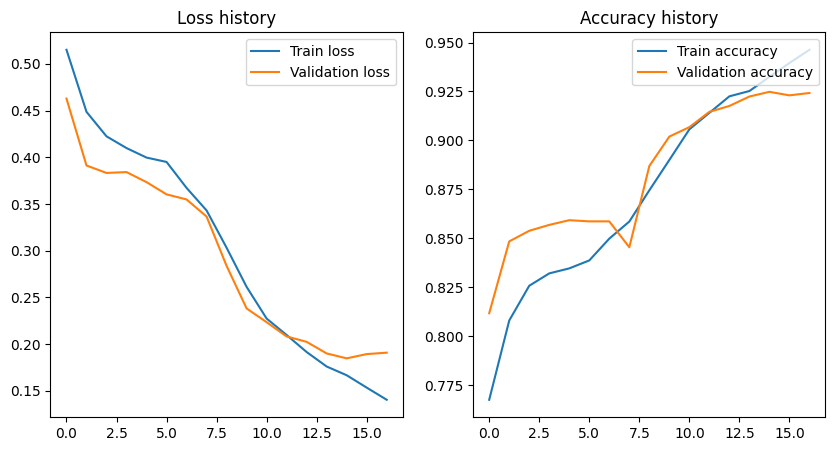

In [264]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss history')
ax[0].legend(['Train loss', 'Validation loss'],loc='upper right')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Accuracy history')
ax[1].legend(['Train accuracy', 'Validation accuracy'], loc='upper right')

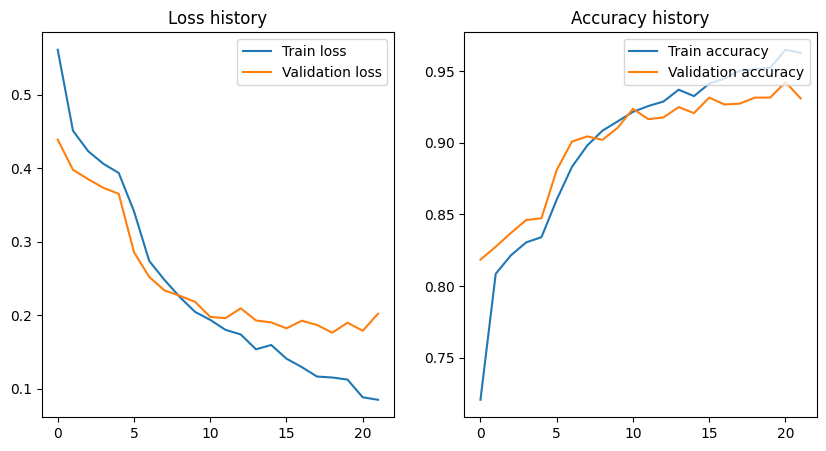

In [210]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Loss history')
ax[0].legend(['Train loss', 'Validation loss'],loc='upper right')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Accuracy history')
ax[1].legend(['Train accuracy', 'Validation accuracy'], loc='upper right')

In [265]:
poi_c2v.save_model('../../data/06_models/chars2vec-150-cosine-BiLSTM-sparsedEnc-Deep-namesDataset-english/')

In [ ]:
poi_c2v.load_model('../../data/06_models/chars2vec-150-cosine-BiLSTM-sparsedEnc-geonames-spanish/')

In [212]:
poi_c2v.model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_branch_input (InputLayer)  [(None, 100, 1)]    0           []                               
                                                                                                  
 right_branch_input (InputLayer  [(None, 100, 1)]    0           []                               
 )                                                                                                
                                                                                                  
 model_4 (Functional)           (None, 300)          723600      ['left_branch_input[0][0]',      
                                                                  'right_branch_input[0][0]']     
                                                                                            

In [266]:
X_test_1 = encode_sparsed_list(X_test[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
X_test_2 = encode_sparsed_list(X_test[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

X_train_1 = encode_sparsed_list(X_train[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
X_train_2 = encode_sparsed_list(X_train[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

In [267]:
test_predictions = poi_c2v.model.predict((X_test_1, X_test_2))
train_predictions = poi_c2v.model.predict((X_train_1, X_train_2))

260/260 [==============================] - 32s 121ms/step



(
    array([303.,  55.,  17.,  14.,  21.,  15.,  11.,  15.,  20., 453.]),
    array([1.23414247e-06, 1.00000493e-01, 1.99999750e-01, 2.99998999e-01,
       3.99998248e-01, 4.99997526e-01, 5.99996746e-01, 6.99996054e-01,
       7.99995303e-01, 8.99994552e-01, 9.99993801e-01]),
    <BarContainer object of 10 artists>
)

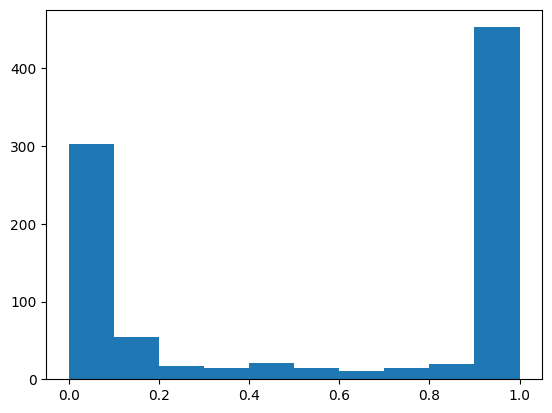

In [268]:
plt.hist(test_predictions)

In [215]:
pd.crosstab((y_train>=.75).flatten(), (train_predictions>=.5).flatten())

col_0,False,True
row_0,,
False,3341,133
True,118,4719


In [270]:
print(classification_report((y_train>=.5).flatten(), (train_predictions>=.5).flatten()))

              precision    recall  f1-score   support

       False       0.95      0.95      0.95      3474
        True       0.96      0.96      0.96      4837

    accuracy                           0.96      8311
   macro avg       0.96      0.96      0.96      8311
weighted avg       0.96      0.96      0.96      8311



In [271]:
pd.crosstab((y_test>=.75).flatten(), (test_predictions>=.5).flatten())

col_0,False,True
row_0,,
False,366,27
True,44,487


In [272]:
print(classification_report((y_test>=.5).flatten(), (test_predictions>=.5).flatten()))

              precision    recall  f1-score   support

       False       0.89      0.93      0.91       393
        True       0.95      0.92      0.93       531

    accuracy                           0.92       924
   macro avg       0.92      0.92      0.92       924
weighted avg       0.92      0.92      0.92       924



In [273]:
from fuzzywuzzy import fuzz

In [274]:
token_set_predictions = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in X_test])
token_set_predictions_train = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in X_train])

In [275]:
pd.crosstab((y_test>=.5).flatten(), token_set_predictions>.75)

col_0,False,True
row_0,,
False,164,229
True,26,505


In [276]:
print(classification_report((y_test>=.75).flatten(), token_set_predictions>.75))

              precision    recall  f1-score   support

       False       0.86      0.42      0.56       393
        True       0.69      0.95      0.80       531

    accuracy                           0.72       924
   macro avg       0.78      0.68      0.68       924
weighted avg       0.76      0.72      0.70       924



In [277]:
pd.crosstab((y_train>=.5).flatten(), token_set_predictions_train>.75)

col_0,False,True
row_0,,
False,1513,1961
True,194,4643


In [278]:
print(classification_report((y_train>=.75).flatten(), token_set_predictions_train>.75))

              precision    recall  f1-score   support

       False       0.89      0.44      0.58      3474
        True       0.70      0.96      0.81      4837

    accuracy                           0.74      8311
   macro avg       0.79      0.70      0.70      8311
weighted avg       0.78      0.74      0.72      8311



In [279]:
results = pd.DataFrame(X_test)
results['prediction'] = test_predictions
results['token_set_ratio'] = token_set_predictions
results['label'] = y_test
results.columns = ['name_1', 'name_2', 'prediction','token_set_ratio', 'label']
results['error'] = results['prediction'] != results['label']

In [280]:
results_train = pd.DataFrame(X_train)
results_train['prediction'] = train_predictions
results_train['token_set_ratio'] = token_set_predictions_train
results_train['label'] = y_train
results_train.columns = ['name_1', 'name_2', 'prediction','token_set_ratio', 'label']
results_train['error'] = (results_train['prediction']>.5).astype(int) != results_train['label'].astype(int)

In [281]:
results.to_csv('results_test.csv', index=False)
results_train.to_csv('results_train.csv', index=False)

# 6. Prediciton

In [282]:
standard_1 = np.array(['dave smith', 'international business machine corp', 'bill gates', 'william h gates', 'mary miller', 'mary', 'ibm inc', 'ibm inc', 'dave smith', 'royal free hospital', 'royal free hospital emergency room', 'royal free hospital school of medicine'])
standard_2 = np.array(['david smith', 'ibm', 'william gates', 'william a gates', 'mark miller', 'mark', 'ibm corp', 'ibs inc', 'smith dave', 'royal free hospital emergency room', 'royal free hospital immunology', 'royal free hospital immunology'])
standard_target = np.array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])
token_set_ratio = [fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in list(zip(standard_1, standard_2))]

In [283]:
standard_1_vectorized = encode_sparsed_list(standard_1,char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
standard_2_vectorized = encode_sparsed_list(standard_2,char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

In [284]:
standard_predictions = poi_c2v.model.predict((standard_1_vectorized, standard_2_vectorized))

1/1 [==============================] - 0s 123ms/step


In [285]:
pd.DataFrame(list(zip(standard_1, standard_2, standard_target, standard_predictions, token_set_ratio)))

,0,1,2,3,4
0,dave smith,david smith,1,[0.99946195],0.86
1,international business machine corp,ibm,1,[0.0008993209],0.11
2,bill gates,william gates,1,[0.49239737],0.78
3,william h gates,william a gates,0,[0.995741],0.93
4,mary miller,mark miller,0,[0.98180974],0.91
5,mary,mark,0,[0.9997431],0.75
6,ibm inc,ibm corp,1,[0.18037309],0.67
7,ibm inc,ibs inc,0,[0.77445084],0.86
8,dave smith,smith dave,1,[0.008098268],1.00
9,royal free hospital,royal free hospital emergency room,0,[0.96508694],1.00


In [286]:
geonames_pairs = catalog.load('geonames_latin_pairs')
geonames_pairs = geonames_pairs.withColumn('target', when(col('match') == 'true', 1).otherwise(0).cast(FloatType()))
geonames_pairs_es = geonames_pairs.filter(col('language_1').isin(['ES', 'MX']))
geonames_normalized = geonames_pairs_es.withColumn('name_1_normalized', udf_normalize_chars(col('name_1'))) \
                .withColumn('name_2_normalized', udf_normalize_chars(col('name_2')))


name_pairs = geonames_normalized.select('name_1_normalized', 'name_2_normalized').toPandas().values
target = geonames_normalized.select(col('target')).toPandas().astype(float).values

X1 = encode_sparsed_list(name_pairs[:, 0],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)
X2 = encode_sparsed_list(name_pairs[:, 1],char_to_index_dict=char_to_index, max_len=MAX_NAME_LEN)

[08/12/23 19:22:44] INFO     Loading data from 'geonames_latin_pairs' (SparkDataSet)...         ]8;id=566907;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=388061;file:///usr/local/lib/python3.9/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

In [287]:
geonames_predictions = poi_c2v.model.predict((X1, X2))

1708/1708 [==============================] - 210s 123ms/step


In [288]:
pd.crosstab((target>=.75).flatten(), (geonames_predictions>=.5).flatten())

col_0,False,True
row_0,,
False,18117,9284
True,11604,15638


In [290]:
print(classification_report((target>=.5).flatten(), geonames_predictions>.5))

              precision    recall  f1-score   support

       False       0.61      0.66      0.63     27401
        True       0.63      0.57      0.60     27242

    accuracy                           0.62     54643
   macro avg       0.62      0.62      0.62     54643
weighted avg       0.62      0.62      0.62     54643



In [291]:
print(classification_report((target>=.5).flatten(), geonames_predictions>.5))

              precision    recall  f1-score   support

       False       0.61      0.66      0.63     27401
        True       0.63      0.57      0.60     27242

    accuracy                           0.62     54643
   macro avg       0.62      0.62      0.62     54643
weighted avg       0.62      0.62      0.62     54643



In [159]:
from fuzzywuzzy import fuzz

token_set_predictions = np.array([fuzz.token_set_ratio(name1, name2)/100 for name1, name2 in name_pairs])>.75
pd.crosstab((target>=.5).flatten(), token_set_predictions)

col_0,False,True
row_0,,
False,23164,4237
True,7350,19892


In [161]:
print(classification_report((target>=.5).flatten(), token_set_predictions))

              precision    recall  f1-score   support

       False       0.76      0.85      0.80     27401
        True       0.82      0.73      0.77     27242

    accuracy                           0.79     54643
   macro avg       0.79      0.79      0.79     54643
weighted avg       0.79      0.79      0.79     54643

